# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: `18`
* Students: `<Raphaël Reis Nunes`> (for the indivudual submission) or `<>` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [1]:
import numpy as np
from numpy.linalg import matrix_power
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

## Feature graph adjacency matrix

In [2]:
#Load and change name
pd_content = pd.read_csv('data/cora/cora.csv', delimiter='\t', header=None)
pd_content.rename(columns={0: 'paper_id', 1434: 'class_label'}, inplace=True)
pd_content.head()


,paper_id,1,2,3,4,5,6,7,8,9,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,class_label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [3]:
#Field paper count
pd_content['class_label'].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [4]:
#Select the genetic algorithms and drop the class_label once it's filtered
my_field = 'Probabilistic_Methods'
features = pd_content[pd_content['class_label'] == my_field].drop('class_label', axis=1)

#Keep paper ids to select futur citation graph in next steps
paper_ids = features['paper_id']
N = features.shape[0]
features.drop('paper_id', axis=1, inplace=True)

features.shape

(426, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [5]:
#Calculate the euclidean distance between each pair features
feat = features.values
distance = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        distance[i, j] = np.sqrt(np.sum(np.square(feat[i,:] - feat[j, :])))

Check the mean pairwise distance $\mathbb{E}[D]$.

In [6]:
mean_distance = distance.mean()
mean_distance

5.790575729028696

Plot an histogram of the euclidean distances.

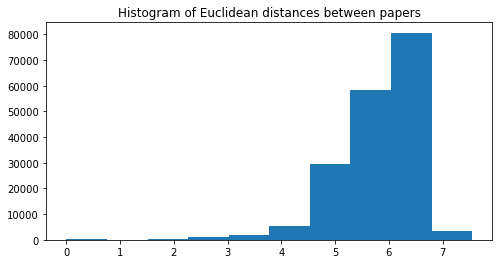

In [7]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [8]:
#Algorithm to create the edges
threshold = mean_distance
A_feature = distance.copy()
A_feature[A_feature < threshold] = 1
A_feature[A_feature >= threshold] = 0
A_feature -= np.identity(A_feature.shape[0])
A_feature.shape

(426, 426)

## Citation adjacency matrix

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [9]:
#Make the idx paper_id map
idx_map = paper_ids.reset_index(drop=True)
idx_map = pd.Series(idx_map.index, index=idx_map.values)

In [10]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')

In [11]:
cora_df = pd.DataFrame(cora_cites, columns=['cited', 'citing'])
cora_df = cora_df.astype('int')
cora_df.head()

,cited,citing
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [12]:
#Make the adjacency matrix for citation
A_citation = np.zeros((N, N), dtype=int)
A_citation.shape

for idx, row in cora_df.iterrows():
    i, j = int(row.cited), int(row.citing)
    if (i in idx_map.index) and (j in idx_map.index):
        A_citation[idx_map[i], idx_map[j]] = 1  # weight
        A_citation[idx_map[j], idx_map[i]] = 1  # weight to obtain an undirected network

Above are the papers that are not neither citing or cited by the other "my_field" but cite or are cited by another field paper. To overcome this issue, we suggest to padd the A_citing array by 2 times values.

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [13]:
assert not np.count_nonzero(A_citation - A_citation.transpose()),\
        "The adjacency matrix is not symmetric"

Check the shape of your adjacency matrix again.

In [14]:
A_citation.shape

(426, 426)

In [15]:
np.save('data/A_citation', A_citation)
np.save('data/A_feature', A_feature)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [16]:
#Load consistent adjacency matrices
A_citation = np.load('data/A_citation.npy')
A_feature = np.load('data/A_feature.npy')

In [17]:
#Check the shape of both graph adjacency matrices
A_citation.shape, A_feature.shape

((426, 426), (426, 426))

In [18]:
#Number of edges for each graph
num_edges_feature = int(np.sum(A_feature)/2)
num_edges_citation = int(np.sum(A_citation)/2)

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 34695
Number of edges in the citation graph: 660


Plot the degree distribution histogram for each of the graphs.

In [19]:
def get_degree_sequence(A_matrix):
    return pd.DataFrame(A_matrix).sum()

In [20]:
degrees_citation = get_degree_sequence(A_citation)
degrees_feature = get_degree_sequence(A_feature)

deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

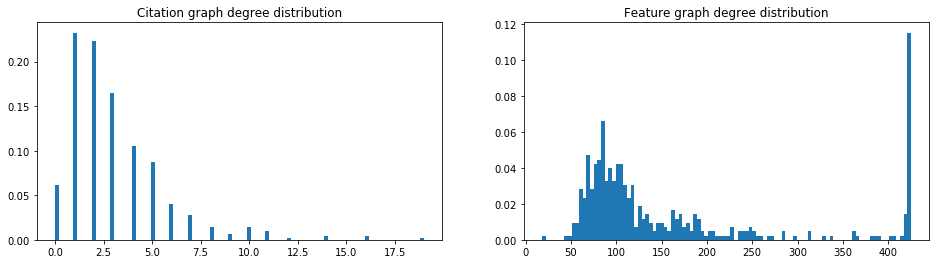

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization, bins=100);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization, bins=100);

Calculate the first and second moments of the degree distribution of each graph.

In [22]:
def compute_moment(degree_series, order=1):
    c_count = degree_series.value_counts() / len(degree_series)
    if order == 1:
        return np.sum(c_count.index * c_count.values)
    if order == 2:
        return np.sum(c_count.index**2 * c_count.values)
    else:
        print("this order is not implemented")

In [23]:
#Strictly speaking, the moment is given by the following
cit_moment_1 = compute_moment(degrees_citation, 1)
cit_moment_2 = compute_moment(degrees_citation, 2)

feat_moment_1 = compute_moment(degrees_feature, 1)
feat_moment_2 = compute_moment(degrees_feature, 2)

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 3.0985915492957745
2nd moment of citation graph: 16.605633802816904
1st moment of feature graph: 162.88732394366198
2nd moment of feature graph: 40686.17840375587


In [24]:
#But in common sense (and as suggested by assitant) we could use mean (exact 1 order moment)
#and variance (2 order moment corrected by the mean)
cit_mean = np.mean(degrees_citation)
cit_var = np.var(degrees_citation)

feat_mean = np.mean(degrees_feature)
feat_var = np.var(degrees_feature)

print(f"1st moment of citation graph: {cit_mean}")
print(f"2nd moment of citation graph: {cit_var}")
print(f"1st moment of feature graph: {feat_mean}")
print(f"2nd moment of feature graph: {feat_var}")

1st moment of citation graph: 3.0985915492957745
2nd moment of citation graph: 7.004364213449712
1st moment of feature graph: 162.88732394366198
2nd moment of feature graph: 14153.898102228397


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:**
_The first moment: gives the mean._

_The second moment: it gives an information on the propency of the graph to have node far from the mean._

_The difference between graph1 and graph2 mean:_
- Most of mass in graph1 is concentrated close to 0. In graph2 even if most of mass seems to be concentrated around  100, there is a large pick at 400+ degree. This shifts the graph2 to mean to the right.

_The difference betweem graph1 and graph2 2de moment:_
- In graph1 the degree distribution is sharp and we don't see degree farther than a distance > 20 from the mean. In graph2, the degree is spread and we see many degree much larger than the mean (162).

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

In [25]:
#Select index of the 20 largest nodes
paper_citation_degree = pd.DataFrame(A_citation).sum()
citation_hubs = paper_citation_degree.sort_values(ascending=False).head(20).index
paper_feature_degree = pd.DataFrame(A_feature).sum()
feature_hubs = paper_feature_degree.sort_values(ascending=False).head(20).index

In [26]:
#Set to 0 all lines and columns corresponding to hubs
A_citation_copy = pd.DataFrame(A_citation).copy()

A_citation_copy.at[citation_hubs] = 0
A_citation_copy.at[:, citation_hubs] = 0

A_feature_copy = pd.DataFrame(A_feature).copy()
A_feature_copy.at[feature_hubs] = 0
A_feature_copy.at[:, feature_hubs] = 0

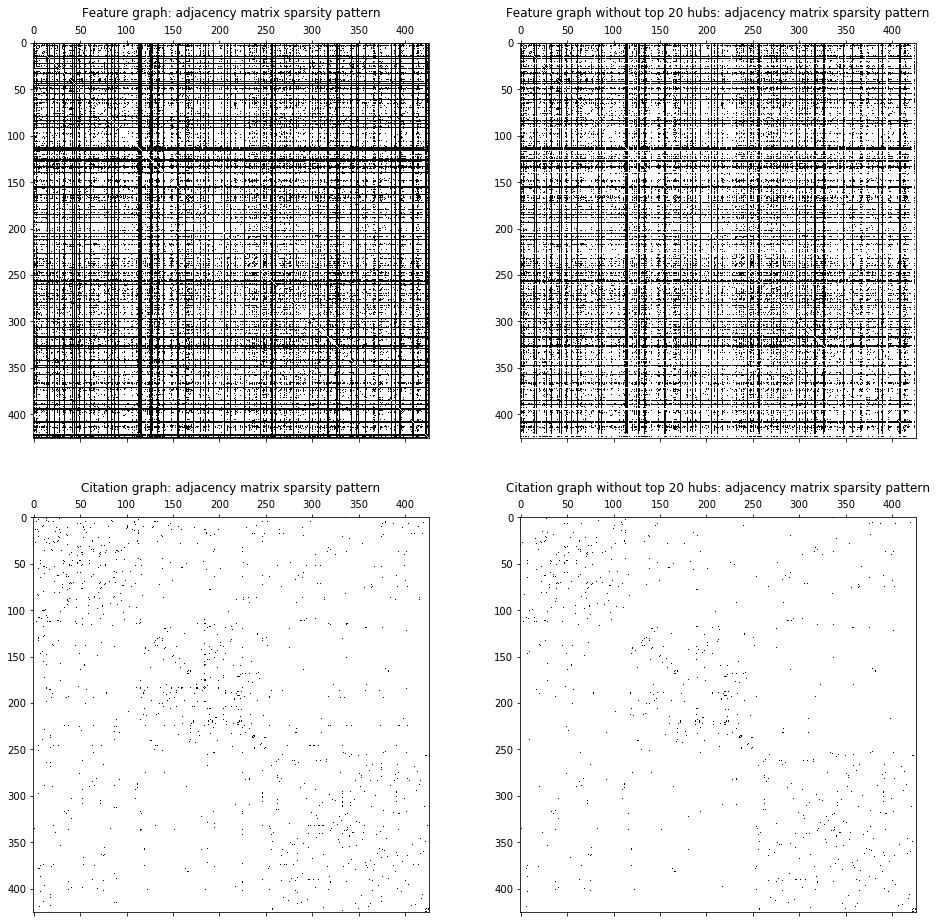

In [27]:
reduced_A_feature = A_feature_copy
reduced_A_citation = A_citation_copy

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

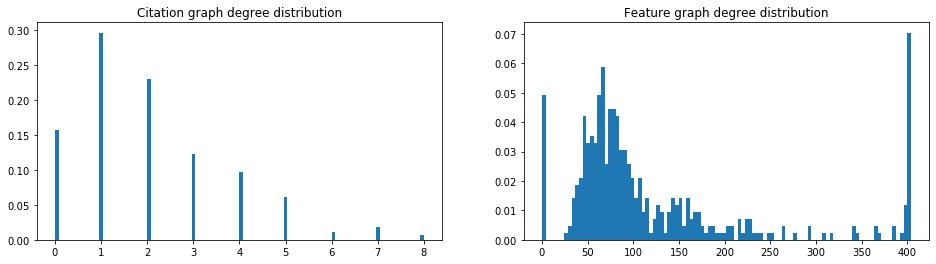

In [28]:
reduced_degrees_feat = get_degree_sequence(reduced_A_feature)
reduced_degrees_cit = get_degree_sequence(reduced_A_citation)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]


fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization, bins=100);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization, bins=100);

Compute the first and second moments for the new graphs.

In [29]:
cit_mean = np.mean(reduced_degrees_cit)
cit_var = np.var(reduced_degrees_cit)

feat_mean = np.mean(reduced_degrees_feat)
feat_var = np.var(reduced_degrees_feat)

print(f"1st moment of citation graph: {cit_mean}")
print(f"2nd moment of citation graph: {cit_var}")
print(f"1st moment of feature graph: {feat_mean}")
print(f"2nd moment of feature graph: {feat_var}")

1st moment of citation graph: 2.0704225352112675
2nd moment of citation graph: 2.887059445877141
1st moment of feature graph: 123.88732394366197
2nd moment of feature graph: 11527.602327580507


In [30]:
reduced_cit_moment_1 = compute_moment(reduced_degrees_cit, 1)
reduced_cit_moment_2 = compute_moment(reduced_degrees_cit, 2)

reduced_feat_moment_1 = compute_moment(reduced_degrees_feat, 1)
reduced_feat_moment_2 = compute_moment(reduced_degrees_feat, 2)


print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 2.0704225352112675
Citation graph second moment: 7.173708920187794
Feature graph first moment:  123.88732394366195
Feature graph second moment:  26875.671361502347


Print the number of edges in the reduced graphs.

In [31]:
# L = 1/2 * sum(ki)
L_citation = (1 / 2) * np.sum(reduced_A_citation.values)
L_feature = (1 / 2) * np.sum(reduced_A_feature.values)

print("Number of edges in citation graph: " + str(L_citation))
print("Number of edges in feature graph: " + str(L_feature))

Number of edges in citation graph: 441.0
Number of edges in feature graph: 26388.0


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

In [32]:
change_cit_moment_1 = reduced_cit_moment_1 / cit_moment_1
change_cit_moment_2 = reduced_cit_moment_2 / cit_moment_2

change_feat_moment_1 = reduced_feat_moment_1 / feat_moment_1
change_feat_moment_2 = reduced_feat_moment_2 / feat_moment_2

print("1st order momentum in citation changed by: " + str(-round((1 - change_cit_moment_1)*100, 2)) + "%")
print("2nd order momentum in citation changed by: " + str(-round((1 - change_cit_moment_2)*100, 2)) + "%")

print("1st order momentum in feature changed by: " + str(-round((1 - change_feat_moment_1)*100, 2)) + "%")
print("2nd order momentum in feature changed by: " + str(-round((1 - change_feat_moment_2)*100, 2)) + "%")

1st order momentum in citation changed by: -33.18%
2nd order momentum in citation changed by: -56.8%
1st order momentum in feature changed by: -23.94%
2nd order momentum in feature changed by: -33.94%


**Your answer here:**

_The effect of removing the hubs is not the same in both graph._

>1. If we look at the distribution, we see that the hubs removing shrinks the degree distribution of the **citation graph** but does not change the **feature graph** a lot (it only decrease the size of the last pick).
>2. According to the relative variation of the moments above, it seems to affect much more the citation graph than the feature graph. 

_This suggests once again a different structure of both graphs._



### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [33]:
#Adjusting the graph edges
threshold = mean_distance - 2.7 #After many trials, it was not possible to go closer than a difference of 117 edges
A_feature_pruned = distance.copy()
A_feature_pruned[A_feature_pruned < threshold] = 1
A_feature_pruned[A_feature_pruned >= threshold] = 0
A_feature_pruned -= np.identity(A_feature_pruned.shape[0])
num_edges_feature_pruned = np.sum(A_feature_pruned.flatten()) / 2

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 34695
Number of edges in the feature graph after pruning: 720.0
Number of edges in the citation graph: 660


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

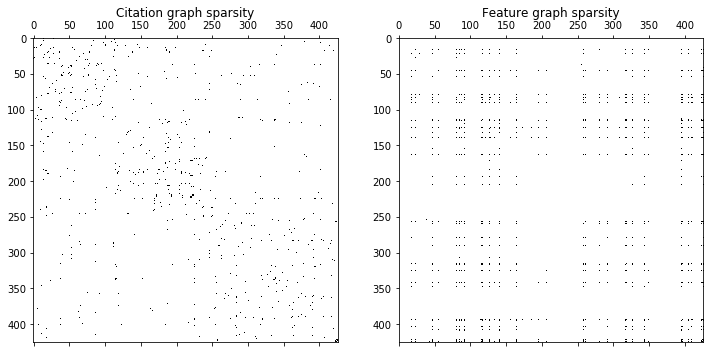

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [35]:
#Helper functions to calculate the path matrix
def compute_matrix_power(matrix, n):
    '''The resulting matrix gives at position (i,j) the number of shortest path of length n from i to j'''
    return matrix_power(matrix, n+1)

def compute_path_matrix(matrix, largest_path_length):
    return sum([compute_matrix_power(matrix, i) for i in range(largest_path_length)])


In [36]:
path_matrix_citation = compute_path_matrix(A_citation, 10)
path_matrix_feature = compute_path_matrix(A_feature, 10)

Check the sparsity pattern for both of path matrices.

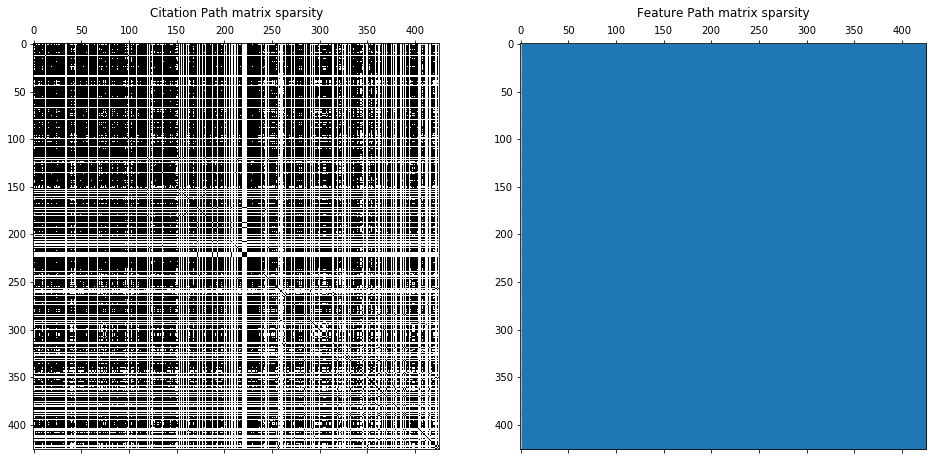

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature, marker=1);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

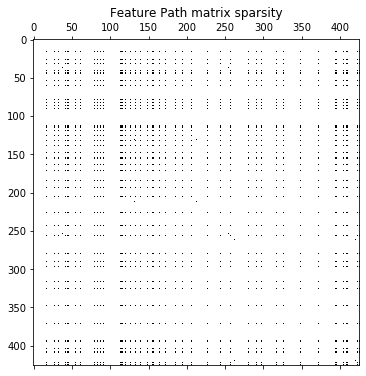

In [38]:
#Compute the path matrix for a feature graph with same number of edges as citation graph
path_matrix_pruned = compute_path_matrix(A_feature_pruned, 10)

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:** 

Yes, unpruned is connected. Whereas pruned graph is not connected

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:**

_A graph is connected if it exists at least one path to go to any node. Visually, a graph is connected if there is no blank line/column (except the diagonal). So yes the unpruned is connected._

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:**  

_The original diameter definition is the maximum shortest path from any two nodes._

_The diameter could be also though as follow: assuming that the graph is connected (meaning that we can go from any node to any other in a finite path length), what is the minimum path length at which any pair of node can be linked together._

_With such definition, since the path matrix counts the number of shortest path from any pair of nodes, if $N_{ij}^{d} = 0$, it means that we have not yet reach $d_{max}$. So to calculate the maximum shortest path, find the $d$ where $N_{ij}^{d} > 0 \space \forall i,j$ and $d_{max} = d$._

If any of your graphs is connected, calculate the diameter using that process.

_Feature graph is connected_

In [39]:
#First approximation of the diameter without using the path matrix,
#since it's guessed to be a power law degree distribution:
int(np.log(A_feature.shape[0]) / np.log(np.log(A_feature.shape[0])))

3

In [40]:
#Helper function
def compute_diameter(A_matrix, max_test=10):
    '''Compute the diameter of a adjacency matrix'''
    #Test that A_matrix is connected:
    assert np.sum(A_matrix, axis=1).min() != 0, "The graph is not connected"
    if A_matrix.min() != 0:
        return 1
    else:
        for i in range(2, max_test+1):
            if compute_path_matrix(A_matrix, i).min() != 0:
                return i
            else: continue
        

In [41]:
diameter = compute_diameter(A_feature)
print(f"The diameter is: {diameter}")

The diameter is: 2


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [42]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [43]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [44]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 426, Number of edges: 660
Number of self-loops: 0, Number of connected components: 48


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [45]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 426, Number of edges: 720
Number of self-loops: 0, Number of connected components: 365


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [46]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

426

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [47]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

690.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:** 

Since the probability for a node to have $k$ edges is follow a binomial law, $$\langle k\rangle = p * (N-1)$$ $$\iff p = \dfrac{\langle{k}\rangle}{(N-1)}$$

We know from the begining of the cours that : $\langle k\rangle = \frac{2L}{N}$ $$\implies p = \frac{2L}{N(N-1)}$$

In [48]:
p = 2 * m / (n*(n))
print(p)
G_er = nx.erdos_renyi_graph(n, p)

0.007604311313892746


In [49]:
print('Number of nodes: {}, Number of edges: {}'. format(G_er.number_of_nodes(), G_er.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_er.number_of_selfloops(), nx.number_connected_components(G_er)))


Number of nodes: 426, Number of edges: 697
Number of self-loops: 0, Number of connected components: 18


Check the number of edges in the Erdős–Rényi graph.

In [50]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network that simulates the citation graph has 697 edges.


How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:** The probability that the new node connects to the node i is given by $P_{i}(k_{i}) = \frac{k_{i}}{\sum k_{j}}$

In [51]:
#Assuming that during the network growing phase, at each timestep the new node connects to
#the same number of nodes, q is given by the devision of the total number of edges and the total number of nodes
q = int(m/n + 1)
G_ba = nx.barabasi_albert_graph(n, q)
print(q)

2


Check the number of edges in the Barabási–Albert graph.

In [52]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network that simulates the citation graph has 848 edges.


In [53]:
print('Number of nodes: {}, Number of edges: {}'. format(G_ba.number_of_nodes(), G_ba.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_ba.number_of_selfloops(), nx.number_connected_components(G_ba)))

Number of nodes: 426, Number of edges: 848
Number of self-loops: 0, Number of connected components: 1


### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [54]:
giant_citation = sorted(nx.connected_component_subgraphs(G_citation), key=len, reverse=True)[0]
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 333 nodes and 582 edges.


In [55]:
giant_feature = sorted(nx.connected_component_subgraphs(G_feature), key=len, reverse=True)[0]
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 59 nodes and 717 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [56]:
giant_er = max(nx.connected_component_subgraphs(G_er), key=len)
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 407 nodes and 695 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:** 

We use the same formula for $p_{new}$ than for p. The difference is that we use the number of nodes and edges in the giant component.

In [57]:
m_ = giant_feature.number_of_edges()
n_ = giant_feature.number_of_nodes()
p_new = 2 * m_ / n_**2
G_er_new = nx.erdos_renyi_graph(n, p_new)
p_new

0.41195058891123243

Check the size of the new Erdős–Rényi network and its giant component.

In [58]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = max(nx.connected_component_subgraphs(G_er_new), key=len)
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

My new Erdos Renyi network that simulates the citation graph has 37155 edges.
The giant component of the new Erdos-Rényi network has 426 nodes and 37155 edges.


### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

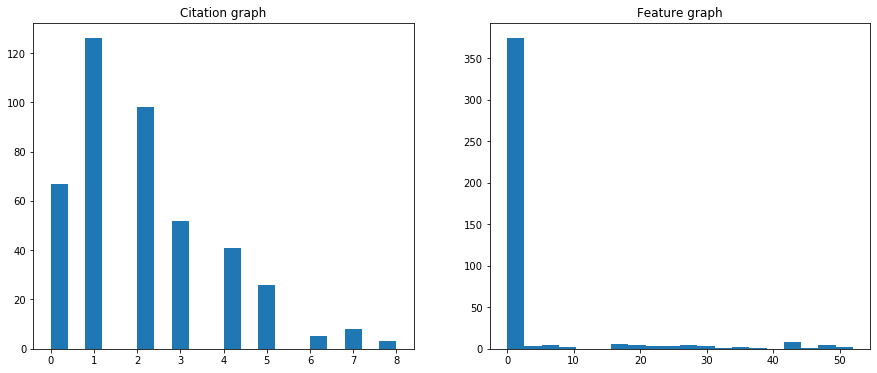

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = get_degree_sequence(reduced_A_citation)
axes[0].hist(citation_degrees, bins=20);
axes[1].set_title('Feature graph')
feature_degrees = get_degree_sequence(A_feature_pruned)
axes[1].hist(feature_degrees, bins=20);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here:** 

>1. Most of citations are around the mean and the variance is low. High number of word proximity relation is not rare  even if most of them are around 2. 
>2. A guess of the network model type would be a **poisson distribution for the citation graph** and a **power law for the feature graph**. The second guess is due to the relatively numerous degree far from the mean.

Now, plot the degree distribution historgrams for the simulated networks.

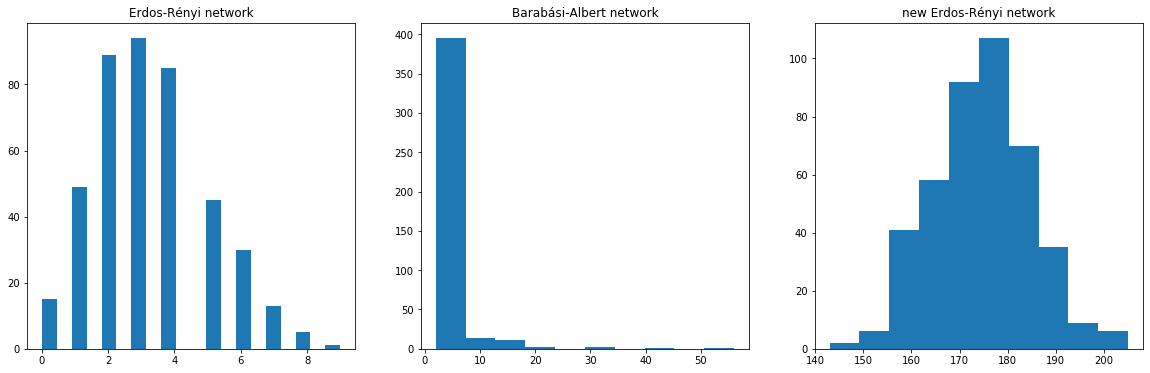

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = list(dict(G_er.degree()).values())
axes[0].hist(er_degrees, bins=20);
axes[1].set_title('Barabási-Albert network')
ba_degrees= list(dict(G_ba.degree()).values())
axes[1].hist(ba_degrees);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees= list(dict(G_er_new.degree()).values())
axes[2].hist(er_new_degrees);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** 

_The citation graph fits well Erdos-Rényi the  model. The feature graph fits well the Barabási-Albert model._

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [61]:
G_config = nx.configuration_model(feature_degrees.astype(int).values) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Configuration model has 426 nodes and 720 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** 

_No, we don't create the same graph. The configuration model keeps that degree distribution only. However the nodes could be switched at each iteration_

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [62]:
nx.average_clustering(G_citation)

0.2402694603120846

In [63]:
feature_c_coef = nx.average_clustering(G_feature)

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:**

_The clustering coefficient tells us how connected in average is the netork. Probability interpretation tells us that $<C>$ is the probablity that two neighbors of randomely selected node link to each other._

_This means that both networks are poorly connected and that citation graph is more connected than feature graph._

Now, let us check the average clustering coefficient for the simulated networks.

In [64]:
nx.average_clustering(G_er)

0.010863328116849242

In [65]:
nx.average_clustering(G_ba)

0.04594646337054149

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:**

_The clustering coefficients are out of the scope. This means that eventhough we are able to approximate correctly degree distributions, with the simulation models, we are not able to simulate the clustering coefficient properly._

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:**

Since: 
1. The feature graph seems to fit a power law degree distribution
2. We want to keep the clustering coefficient

It seems that powerlaw_cluster_graph is a good candidate

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

Power Law Model:
Number of nodes: 426, Number of edges: 848
Number of self-loops: 0, Number of connected components: 1
Model clustering coefficient: 0.10391546430810039

Feature Graph
Number of nodes: 426, Number of edges: 720
Number of self-loops: 0, Number of connected components: 365
Feature graph clustering coefficient: 0.10990779169766017


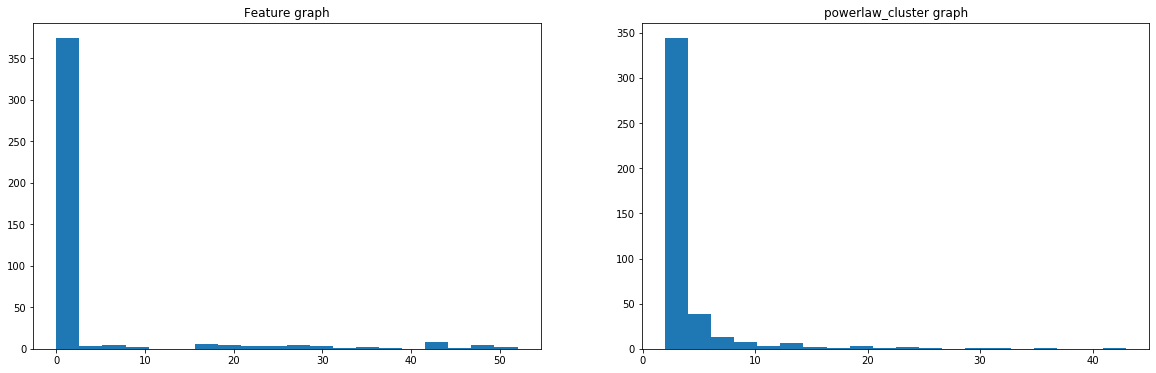

In [66]:
#Power law clustering model
p = 0.08
_m_ = int(m/n + 1)
G_powerlaw_cluster = nx.powerlaw_cluster_graph(n, _m_, p, seed=1)
c_coef = nx.average_clustering(G_powerlaw_cluster)
print("Power Law Model:")
print('Number of nodes: {}, Number of edges: {}'. format(G_powerlaw_cluster.number_of_nodes(), G_powerlaw_cluster.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_powerlaw_cluster.number_of_selfloops(), nx.number_connected_components(G_powerlaw_cluster)))
print("Model clustering coefficient: " + str(c_coef))

#Feature graph
print("\nFeature Graph")
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))
print("Feature graph clustering coefficient: " + str(feature_c_coef))

#Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].set_title('Feature graph')
feature_degrees = get_degree_sequence(A_feature_pruned)
axes[0].hist(feature_degrees, bins=20);

axes[1].set_title("powerlaw_cluster graph")
axes[1].hist(list(dict(G_powerlaw_cluster.degree).values()), bins=20);


Comment on the similarities of your match.

**Your answer here:**

>1. The degree distribution is similar.
>2. This time we are able to fit the clustering coefficient.
>3. The number of edges of the same order even if the model overestimates it.
>4. The model does not fit the number of connected components _at all_.

**Comment :**
As expected, the model is able to fit the degree distribution distribution in addition to the clustering coefficient.